In [43]:
import pandas as pd

# Load the CSV file
file_path = 'Electric_Vehicle_Population_Size_History_By_County.csv'
ev_data = pd.read_csv(file_path)

# Display the first few rows of the dataframe
ev_data.head()


,Date,County,State,Vehicle Primary Use,Battery Electric Vehicles (BEVs),Plug-In Hybrid Electric Vehicles (PHEVs),Electric Vehicle (EV) Total,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles
0,April 30 2022,Wahkiakum,WA,Truck,0,0,0,1815,1815,0.00
1,May 31 2017,Adams,WA,Truck,0,0,0,5079,5079,0.00
2,October 31 2019,Collin,TX,Passenger,2,1,3,142,145,2.07
3,January 31 2024,Franklin,WA,Truck,10,0,10,20616,20626,0.05
4,February 28 2018,Grays Harbor,WA,Truck,0,0,0,20109,20109,0.00


In [3]:
# Filter for Washington State data
wa_ev_data = ev_data[ev_data['State'] == 'WA']

# Group by Date and sum up the total electric vehicles
wa_ev_totals = wa_ev_data.groupby('Date')['Electric Vehicle (EV) Total'].sum().reset_index()

# Convert 'Date' to datetime and sort by it
wa_ev_totals['Date'] = pd.to_datetime(wa_ev_totals['Date'])
wa_ev_totals = wa_ev_totals.sort_values('Date')

# Display the summarized data
wa_ev_totals.head()


,Date,Electric Vehicle (EV) Total
29,2017-01-31,21798
21,2017-02-28,22473
51,2017-03-31,23065
0,2017-04-30,23743
59,2017-05-31,24352


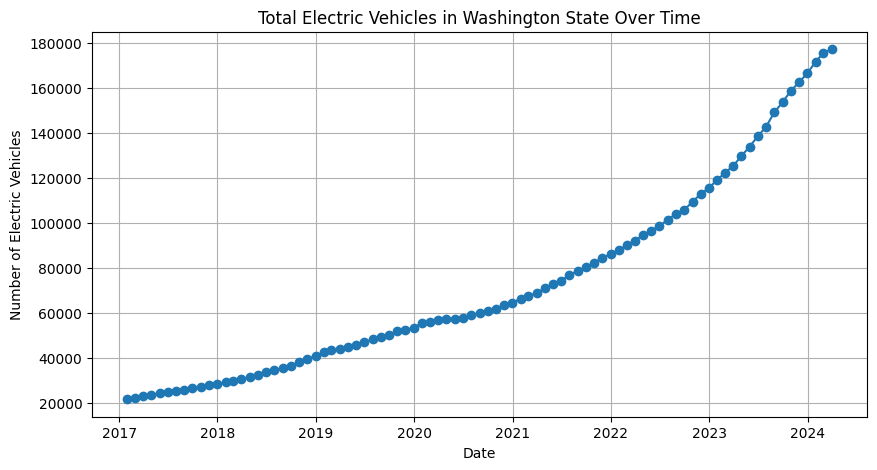

In [4]:
import matplotlib.pyplot as plt

# Plotting the data
plt.figure(figsize=(10, 5))
plt.plot(wa_ev_totals['Date'], wa_ev_totals['Electric Vehicle (EV) Total'], marker='o')
plt.title('Total Electric Vehicles in Washington State Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Electric Vehicles')
plt.grid(True)
plt.show()


In [17]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

url = 'https://afdc.energy.gov/vehicle-registration'  # Confirm the URL
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

# Depending on the structure which we need to identify first
data_rows = soup.find_all('tr')
state_ev_data = []
for row in data_rows:
    cells = row.find_all('td')
    if len(cells) > 1:
        state = cells[0].text.strip()
        ev_count_str = cells[1].text.strip().replace(',', '')
        if ev_count_str.isdigit():
            ev_count = int(ev_count_str)
            state_ev_data.append((state, ev_count))

ev_registrations = pd.DataFrame(state_ev_data, columns=['State', 'EV Registrations'])
print(ev_registrations)


                   State  EV Registrations
0                Alabama              8700
1                 Alaska              2000
2                Arizona             65800
3               Arkansas              5100
4             California            903600
5               Colorado             59900
6            Connecticut             22000
7               Delaware              5400
8   District of Columbia              5900
9                Florida            168000
10               Georgia             60100
11                Hawaii             19800
12                 Idaho              5900
13              Illinois             66900
14               Indiana             17700
15                  Iowa              6200
16                Kansas              7600
17              Kentucky              7600
18             Louisiana              5900
19                 Maine              5000
20              Maryland             46100
21         Massachusetts             49400
22         

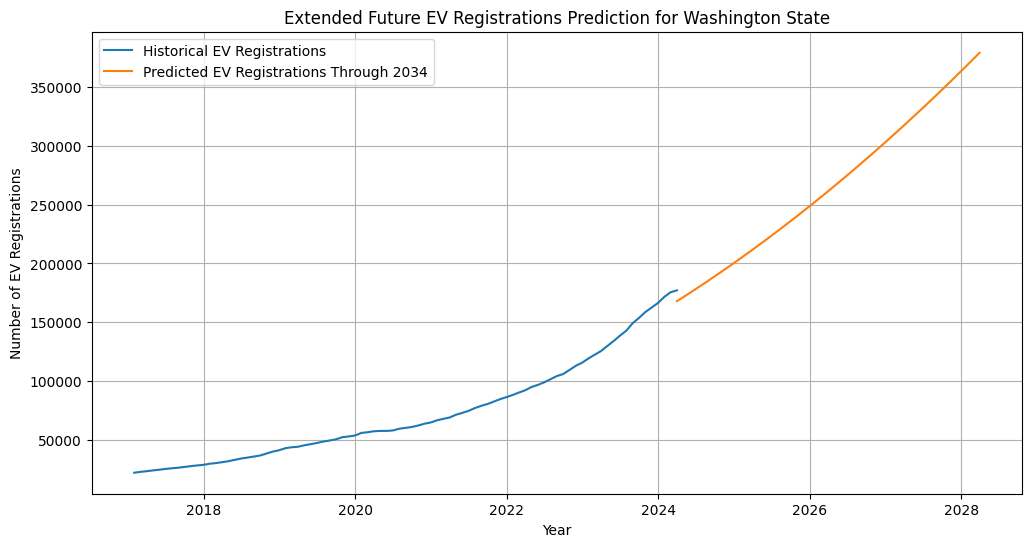

In [45]:
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'wa_ev_totals' is already loaded and cleaned
wa_ev_totals['Date'] = pd.to_datetime(wa_ev_totals['Date'])
wa_ev_totals['TimeIndex'] = (wa_ev_totals['Date'] - wa_ev_totals['Date'].min()).dt.days  # Convert dates to a numeric value for regression

# Define the prediction endpoint
latest_date = wa_ev_totals['Date'].max()
target_year = 2028
years_to_predict = target_year - latest_date.year

# Generate future dates through 2034
future_times = pd.date_range(start=latest_date, periods=365 * years_to_predict, freq='D')
future_time_index_df = pd.DataFrame({'TimeIndex': (future_times - wa_ev_totals['Date'].min()).days})  # Use DataFrame instead of np.array

# Model fitting with Polynomial Regression
degree = 2  # Degree of polynomial features
poly_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
poly_model.fit(wa_ev_totals[['TimeIndex']], wa_ev_totals['Electric Vehicle (EV) Total'])  # Fit the model

# Predict future EV registrations using DataFrame to maintain feature names
future_preds_poly = poly_model.predict(future_time_index_df)

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(wa_ev_totals['Date'], wa_ev_totals['Electric Vehicle (EV) Total'], label='Historical EV Registrations')
plt.plot(future_times, future_preds_poly, label='Predicted EV Registrations Through 2034')
plt.title('Extended Future EV Registrations Prediction for Washington State')
plt.xlabel('Year')
plt.ylabel('Number of EV Registrations')
plt.legend()
plt.grid(True)
plt.show()


In [34]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

# Assuming the setup of the poly_model and wa_ev_totals are correct and previously defined

# Set the number of days from the start for the prediction date
future_date = pd.to_datetime('2034-12-31')
days_since_start = (future_date - wa_ev_totals['Date'].min()).days
future_time_index = np.array([[days_since_start]])

# Use the trained model to predict
future_pred = poly_model.predict(future_time_index)

# Calculate trend factor as the ratio of future prediction to the latest known data point
washington_latest_ev_count = wa_ev_totals['Electric Vehicle (EV) Total'].iloc[-1]
trend_factor = future_pred[0] / washington_latest_ev_count

# Apply this trend factor to the nationwide data
ev_registrations['Predicted 2034 Registrations'] = ev_registrations['EV Registrations'] * trend_factor

# Set display format to avoid scientific notation
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Display the DataFrame with all states
print(ev_registrations[['State', 'EV Registrations', 'Predicted 2034 Registrations']])


                   State  EV Registrations  Predicted 2034 Registrations
0                Alabama              8700                      46960.98
1                 Alaska              2000                      10795.63
2                Arizona             65800                     355176.14
3               Arkansas              5100                      27528.85
4             California            903600                    4877464.44
5               Colorado             59900                     323329.04
6            Connecticut             22000                     118751.90
7               Delaware              5400                      29148.19
8   District of Columbia              5900                      31847.10
9                Florida            168000                     906832.70
10               Georgia             60100                     324408.60
11                Hawaii             19800                     106876.71
12                 Idaho              5900         

c:\Python310\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


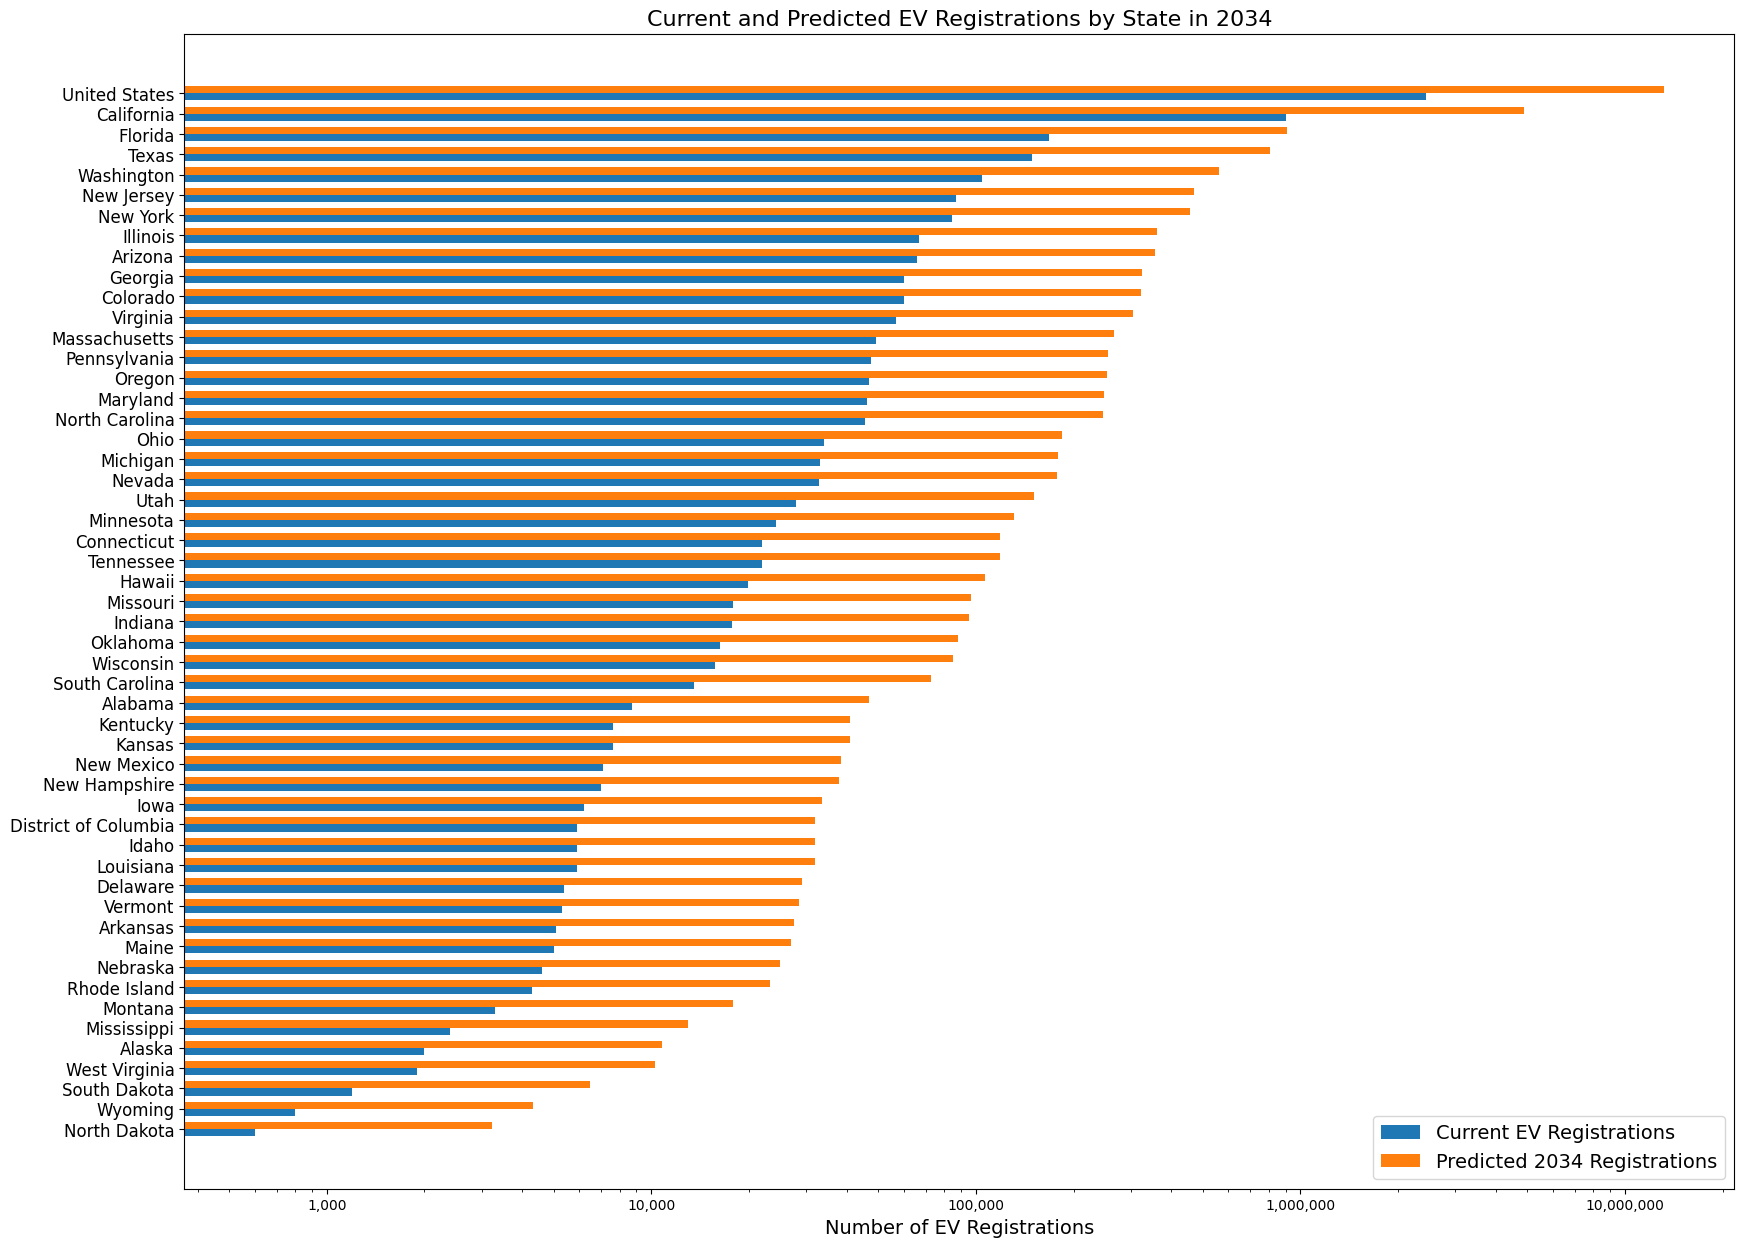

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker

# Ensure data is sorted for better visual comparison
ev_registrations_sorted = ev_registrations.sort_values(by='Predicted 2034 Registrations', ascending=True)

# Creating a side-by-side bar graph with larger size
fig, ax = plt.subplots(figsize=(20, 15))
ind = np.arange(len(ev_registrations_sorted))  # the x locations for the groups
width = 0.35  # the width of the bars

rects1 = ax.barh(ind - width/2, ev_registrations_sorted['EV Registrations'], width, label='Current EV Registrations')
rects2 = ax.barh(ind + width/2, ev_registrations_sorted['Predicted 2034 Registrations'], width, label='Predicted 2034 Registrations')

# Add some text for labels, title and axes ticks
ax.set_xlabel('Number of EV Registrations', fontsize=14)
ax.set_title('Current and Predicted EV Registrations by State in 2034', fontsize=16)
ax.set_yticks(ind)
ax.set_yticklabels(ev_registrations_sorted['State'], fontsize=12)

# Format x-axis to use a logarithmic scale
ax.set_xscale('log')
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))  # Format with commas, no decimals

# Set legend and remove bar labels for a cleaner look
ax.legend(fontsize=14)

plt.show()
